# Action2：资金流入流出预测
https://tianchi.aliyun.com/competition/entrance/231573/information
数据集一共包括4张表：用户基本信息数据、用户申购赎回数据、收益率表和银行间拆借利率表
2.8万用户，284万行为数据，294天拆解利率，427天收益率
2013-07-01到2014-08-31，预测2014年9月的申购和赎回

### 数据探索

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

%matplotlib inline

In [2]:
user_balance = pd.read_csv('./user_balance_table.csv', parse_dates=['report_date'])
user_balance.head()

,user_id,report_date,tBalance,yBalance,total_purchase_amt,direct_purchase_amt,purchase_bal_amt,purchase_bank_amt,total_redeem_amt,consume_amt,transfer_amt,tftobal_amt,tftocard_amt,share_amt,category1,category2,category3,category4
0,1,2014-08-05,20385,20383,2,0,0,0,0,0,0,0,0,2,NaN,NaN,NaN,NaN
1,1,2014-08-08,20391,20389,2,0,0,0,0,0,0,0,0,2,NaN,NaN,NaN,NaN
2,1,2014-08-11,20397,20395,2,0,0,0,0,0,0,0,0,2,NaN,NaN,NaN,NaN
3,1,2014-08-14,20403,20401,2,0,0,0,0,0,0,0,0,2,NaN,NaN,NaN,NaN
4,1,2014-08-17,20409,20407,2,0,0,0,0,0,0,0,0,2,NaN,NaN,NaN,NaN


In [3]:
# 对关键字段进行统计
# 关键字段：total_purchase_amt、total_redeem_amt
total_balance = user_balance.groupby(['report_date'])['total_purchase_amt', 'total_redeem_amt'].sum()
total_balance

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  This is separate from the ipykernel package so we can avoid doing imports until


,total_purchase_amt,total_redeem_amt
report_date,,
2013-07-01,32488348,5525022
2013-07-02,29037390,2554548
2013-07-03,27270770,5953867
2013-07-04,18321185,6410729
2013-07-05,11648749,2763587
...,...,...
2014-08-27,302194801,468164147
2014-08-28,245082751,297893861
2014-08-29,267554713,273756380


In [15]:
purchase = total_balance['total_purchase_amt']
redeem = total_balance['total_redeem_amt']

Text(0.5, 1.0, '日申购赎回时序图')

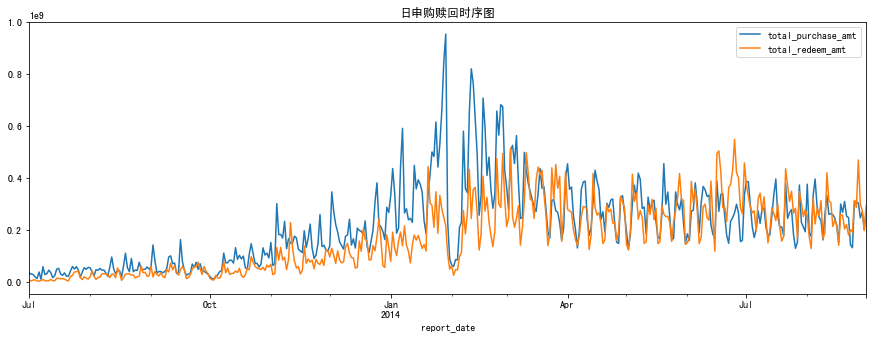

In [4]:
# 绘制时序图
fig = plt.subplots(figsize=(15,5))
ax0 = plt.subplot2grid((1,1),(0,0))
total_balance.plot(ax=ax0)
ax0.set_title('日申购赎回时序图')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  after removing the cwd from sys.path.


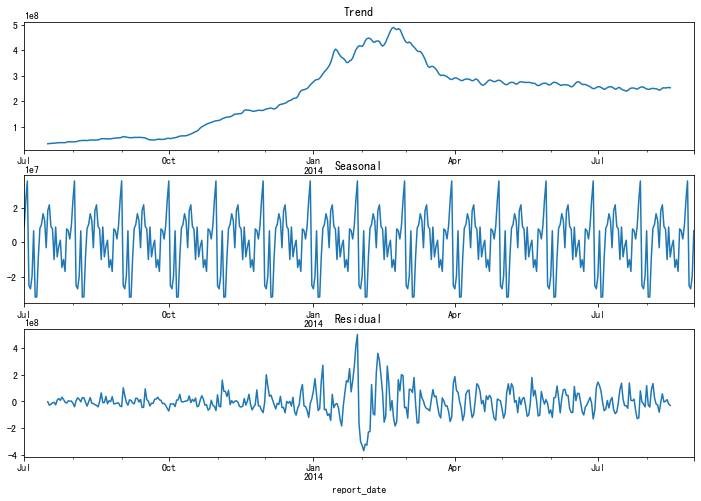

In [5]:
# 对指定范围内的数据进行可视化分析
def plot_stl(data,f=30):
    # STL分解，将数据拆分为：Trend + Seasonal + Residual
    stl = sm.tsa.seasonal_decompose(data, freq = f)
    # 可视化
    fig = plt.figure(figsize=(12,8))
    ax1 = fig.add_subplot(311)
    ax2 = fig.add_subplot(312)
    ax3 = fig.add_subplot(313)
    
    stl.trend.plot(ax=ax1, title='Trend')
    stl.seasonal.plot(ax=ax2, title='Seasonal')
    stl.resid.plot(ax=ax3, title='Residual')

# 月总购买量趋势    
plot_stl(total_balance['total_purchase_amt'])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  after removing the cwd from sys.path.


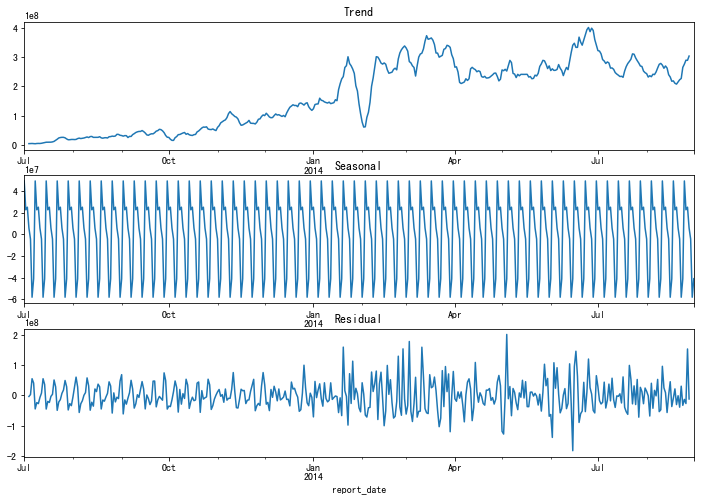

In [6]:
# 周总赎回量趋势
plot_stl(total_balance['total_redeem_amt'],f=7)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  after removing the cwd from sys.path.


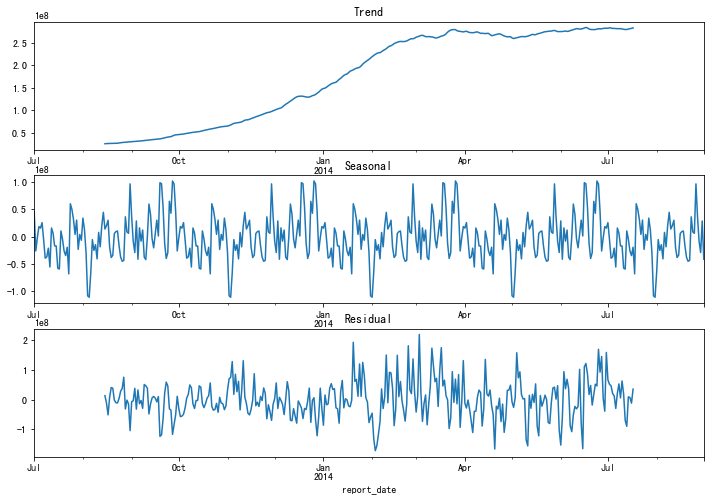

In [7]:
# 季度总赎回量趋势
plot_stl(total_balance['total_redeem_amt'],f=90)

In [8]:
# 使用ADF对数据的平稳性进行检验
from statsmodels.tsa.stattools import adfuller

adf_purchase = adfuller(total_balance['total_purchase_amt'])
adf_purchase  # 因结果小于-1.5，无法拒绝原假设，所以数据不平稳

(-1.5898802926313507,
 0.4886749751375928,
 18,
 408,
 {'1%': -3.446479704252724,
  '5%': -2.8686500930967354,
  '10%': -2.5705574627547096},
 15960.28197033403)

In [9]:
adf_redeem = adfuller(total_balance['total_redeem_amt'])
adf_redeem # 数据不平稳

(-1.372413679828339,
 0.5954275877949474,
 13,
 413,
 {'1%': -3.4462831955497135,
  '5%': -2.8685636962704395,
  '10%': -2.5705114078759914},
 15816.780952766481)

In [10]:
# 对不平稳的数据进行一阶差分
purchase_diff1 = total_balance['total_purchase_amt'].diff(1)
purchase_diff1 = purchase_diff1.dropna(how=any)
adf_purchase = adfuller(purchase_diff1)

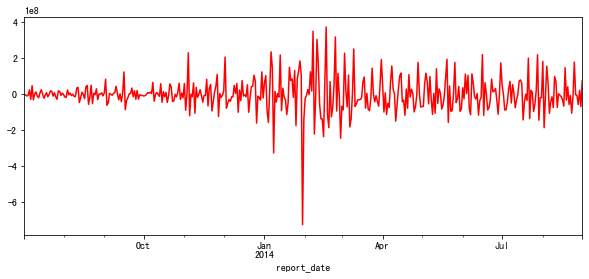

In [11]:
purchase_diff1.plot(figsize=(10,4),c='r')

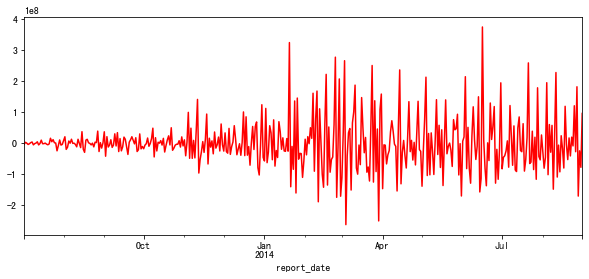

In [12]:
redeem_diff1 = total_balance['total_redeem_amt'].diff(1)
redeem_diff1 = redeem_diff1.dropna(how=any)
adf_redeem = adfuller(redeem_diff1)
redeem_diff1.plot(figsize=(10,4),c='r')

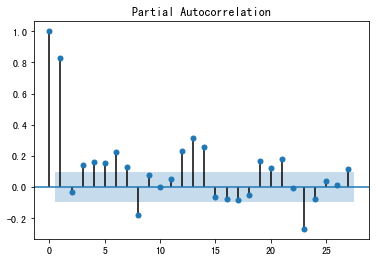

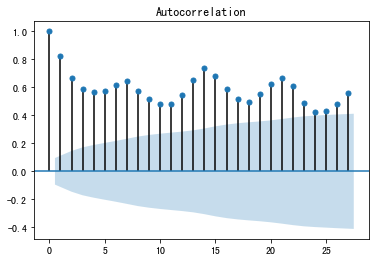

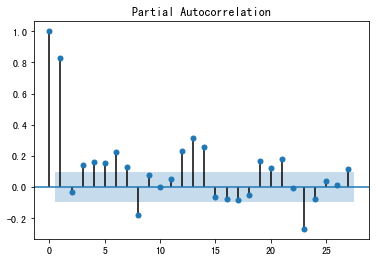

In [18]:
# 自相关和偏自相关图
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(purchase)
plot_pacf(purchase)

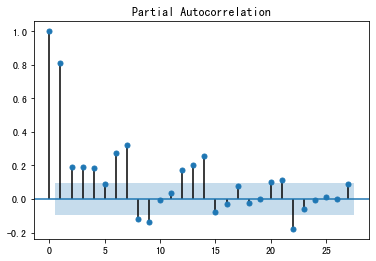

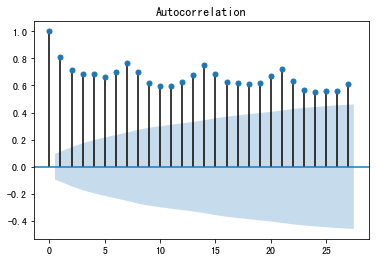

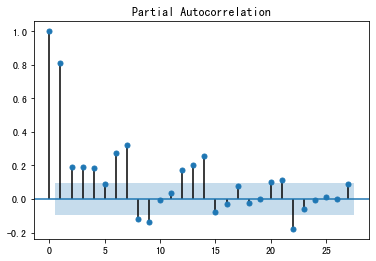

In [17]:
plot_acf(redeem) # 自相关
plot_pacf(redeem)  # 偏自相关

### 建模预测

In [20]:
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm
# pm.arima.ndiffs(purchase, test='adf')

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


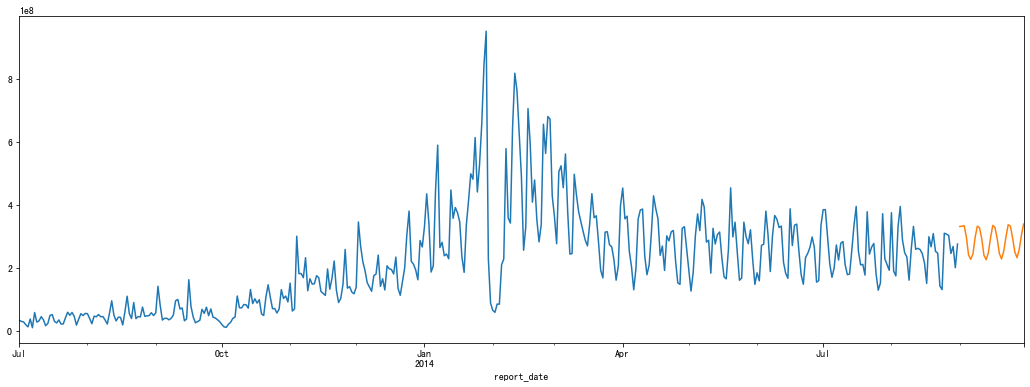

In [24]:
# 1）针对购买purchase建模
# 选择合适的p值，q值
# 对购买进行预测，使用type='level' 对预测数据进行反差分，还原原始数据

model_purchase = ARIMA(purchase,order=(7,1,5)).fit()
purchase_pred = model_purchase.predict('2014-09-01', '2014-09-30',typ='levels')

# 绘图
fig = plt.figure(figsize=(20,6))
axq = fig.add_subplot(111)
purchase.plot(ax=axq)
purchase_pred.plot(ax=axq)

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


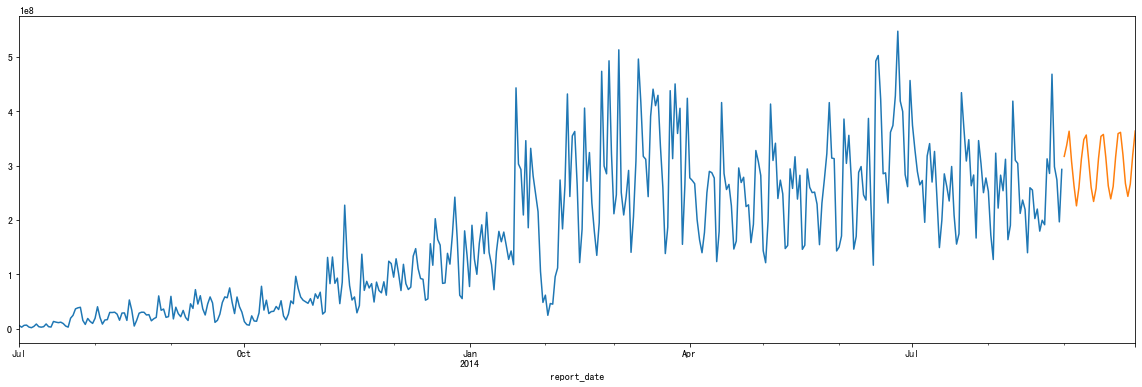

In [39]:
# 2）针对赎回redeem建模
model_redeem = ARIMA(redeem,order=(7,1,5)).fit()
redeem_pred = model_redeem.predict('2014-09-01', '2014-09-30',typ='levels')
# 绘图
fig = plt.figure(figsize=(20,6))
axq = fig.add_subplot(111)
redeem.plot(ax=axq)
redeem_pred.plot(ax=axq)

###  保存结果

In [40]:
result = pd.DataFrame()
result['report_date'] = purchase_pred.index
result['purchase'] = purchase_pred.values
result['redeem'] = redeem_pred.values
# 将report_date中的-删除
result['report_date'] = result['report_date'].apply(lambda x:str(x).replace('-','')[:8])
result

,report_date,purchase,redeem
0,20140901,3.310539e+08,3.169090e+08
1,20140902,3.318762e+08,3.372455e+08
2,20140903,3.338910e+08,3.632442e+08
3,20140904,2.983191e+08,3.074694e+08
4,20140905,2.407509e+08,2.628057e+08
5,20140906,2.266140e+08,2.258706e+08
6,20140907,2.435554e+08,2.592158e+08
7,20140908,2.970865e+08,3.115468e+08
8,20140909,3.321274e+08,3.477437e+08
9,20140910,3.265197e+08,3.562431e+08


In [41]:
# 保存结果到本地
result.to_csv('./result.csv',header=None, index=None)

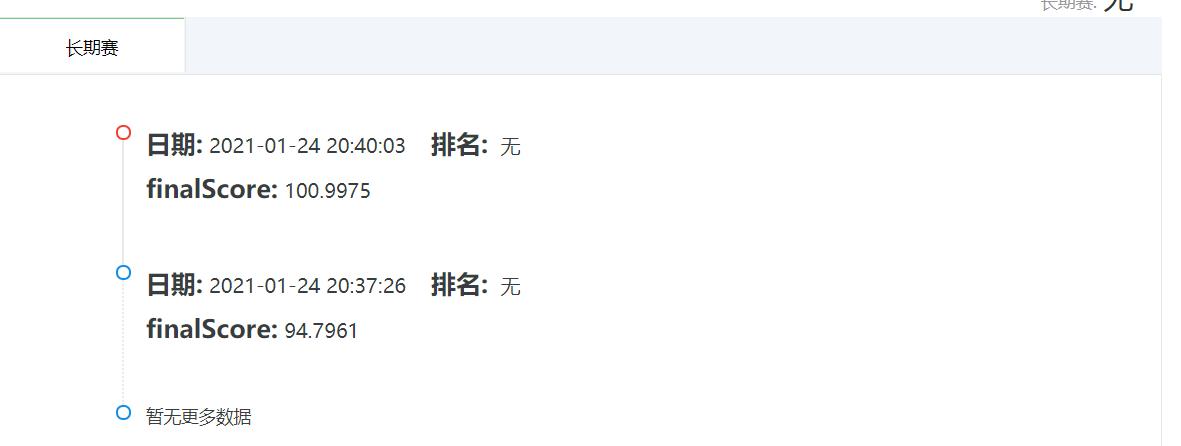

In [4]:
from IPython.display import Image
Image(filename = 'C:/Users/Super/Desktop/result.png', width=500, height=20)

In [45]:
# import math
# import numpy
# import matplotlib.pyplot as plt
# from tensorflow.keras.layers import LSTM, RNN, GRU, SimpleRNN
# from tensorflow.keras.layers import Dense, Dropout
# from tensorflow.keras.callbacks import EarlyStopping
# from tensorflow.keras.models import Sequential
# from sklearn.preprocessing import MinMaxScaler
# import os

# numpy.random.seed(2021)


# class RNNModel(object):
#     def __init__(self, look_back=1, epochs_purchase=20, epochs_redeem=40, batch_size=1, verbose=2, patience=10, store_result=False):
#         self.look_back = look_back
#         self.epochs_purchase = epochs_purchase
#         self.epochs_redeem = epochs_redeem
#         self.batch_size = batch_size
#         self.verbose = verbose
#         self.store_result = store_result
#         self.patience = patience
#         self.purchase = purchase # pandas.read_csv('datalab/25331/date_label.csv', usecols=[1], engine='python') 
#         self.redeem = redeem # pandas.read_csv('datalab/25331/date_label.csv', usecols=[2], engine='python')
        
#     def access_data(self, data_frame):
#         # load the data set
#         data_set = data_frame.values
#         data_set = data_set.astype('float32')

#         # LSTMs are sensitive to the scale of the input data, specifically when the sigmoid (default) or tanh activation functions are used. It can be a good practice to rescale the data to the range of 0-to-1, also called normalizing.
#         scaler = MinMaxScaler(feature_range=(0, 1))
#         data_set = scaler.fit_transform(data_set)

#         # reshape into X=t and Y=t+1
#         train_x, train_y, test = self.create_data_set(data_set)

#         # reshape input to be [samples, time steps, features]
#         train_x = numpy.reshape(train_x, (train_x.shape[0], 1, train_x.shape[1]))
#         return train_x, train_y, test, scaler

#     # convert an array of values into a data set matrix
#     def create_data_set(self, data_set):
#         data_x, data_y = [], []
#         for i in range(len(data_set)-self.look_back - 30):
#             a = data_set[i:(i + self.look_back), 0]
#             data_x.append(a)
#             data_y.append(list(data_set[i + self.look_back: i + self.look_back + 30, 0]))
#         # print(numpy.array(data_y).shape)
#         return numpy.array(data_x), numpy.array(data_y), data_set[-self.look_back:, 0].reshape(1, 1, self.look_back)

#     def rnn_model(self, train_x, train_y, epochs):
#         model = Sequential()
#         model.add(LSTM(64, input_shape=(1, self.look_back), return_sequences=True))
#         model.add(LSTM(32, return_sequences=False))
#         model.add(Dense(32))
#         model.add(Dense(30))
#         model.compile(loss='mean_squared_error', optimizer='adam')
#         model.summary()
#         early_stopping = EarlyStopping('loss', patience=self.patience)
#         history = model.fit(train_x, train_y, epochs=epochs, batch_size=self.batch_size, verbose=self.verbose, callbacks=[early_stopping])
#         return model

#     def predict(self, model, data):
#         prediction = model.predict(data)
#         return prediction

#     def plot_show(self, predict):
#         predict = predict[['purchase', 'redeem']]
#         predict.plot()
#         plt.show()

#     def run(self):
#         purchase_train_x, purchase_train_y, purchase_test, purchase_scaler = self.access_data(self.purchase)
#         redeem_train_x, redeem_train_y, redeem_test, redeem_scaler = self.access_data(self.redeem)

#         purchase_model = self.rnn_model(purchase_train_x, purchase_train_y, self.epochs_purchase)
#         redeem_model = self.rnn_model(redeem_train_x, redeem_train_y, self.epochs_redeem)

#         purchase_predict = self.predict(purchase_model, purchase_test)
#         redeem_predict = self.predict(redeem_model, redeem_test)

#         test_user = pandas.DataFrame({'report_date': [20140900 + i for i in range(1, 31)]})

#         purchase = purchase_scaler.inverse_transform(purchase_predict).reshape(30, 1)
#         redeem = redeem_scaler.inverse_transform(redeem_predict).reshape(30, 1)

#         test_user['purchase'] = purchase
#         test_user['redeem'] = redeem
#         print(test_user)

#         """Store submit file"""
#         if self.store_result is True:
#             test_user.to_csv('submit_lstm.csv', encoding='utf-8', index=None, header=None)
            
#         """plot result picture"""
#         self.plot_show(test_user)
        
# if __name__ == '__main__':
#     initiation = RNNModel(look_back=40, epochs_purchase=150, epochs_redeem=230, batch_size=16, verbose=2, patience=50, store_result=False)
#     initiation.run()
